In [ ]:
!pip install yfinance
!pip install beautifulsoup4
!pip install nltk
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install tensorflow


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install newsapi-python # Install the required library
from newsapi import NewsApiClient

In [ ]:
# @title  Scrape Real News Headlines

# Initialize News API Client (Create a free account at newsapi.org and get your API key)
api_key = '1495790e7b784bafb05c7a66d8e33341'  # <-- Replace YOUR_ACTUAL_API_KEY with your News API key
newsapi = NewsApiClient(api_key=api_key)

# List of stock tickers or companies you are interested in
companies = ['Apple', 'Microsoft', 'Amazon', 'Tesla', 'Google', 'Meta']

# Empty list to collect headlines
headlines = []

for company in companies:
    articles = newsapi.get_everything(q=company, language='en', sort_by='relevancy', page_size=30)
    for article in articles['articles']:
        headlines.append(article['title'])

# Check sample
print(f"Scraped {len(headlines)} headlines")
for i in range(5):
    print(headlines[i])

# Create DataFrame
df = pd.DataFrame(headlines, columns=['headline'])

# Dummy labeling (later you can automate or semi-label manually)
# For now, random 0 or 1 just to proceed. Ideally, you manually label a small batch.
import random
df['sentiment'] = [random.choice([0, 1]) for _ in range(len(df))]

df.head()

Scraped 120 headlines
Apple has a new ‘Viral’ playlist on Apple Music and Shazam
The EU isn’t happy with Apple’s tax on alternative app stores
Spotify already has an app ready to test Apple’s new rules
The Apple Watch Turns 10. Here's How Far It's Come
22 Best MacBook Accessories (2025), Tested and Reviewed


,headline,sentiment
0,Apple has a new ‘Viral’ playlist on Apple Musi...,0
1,The EU isn’t happy with Apple’s tax on alterna...,0
2,Spotify already has an app ready to test Apple...,1
3,The Apple Watch Turns 10. Here's How Far It's ...,1
4,"22 Best MacBook Accessories (2025), Tested and...",0


In [ ]:
# @title Preprocessing

X = df['headline']
y = df['sentiment']

tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf.fit_transform(X)

In [ ]:
# @title Train Models

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# 1. Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.31      0.33      0.32        12
           1       0.27      0.25      0.26        12

    accuracy                           0.29        24
   macro avg       0.29      0.29      0.29        24
weighted avg       0.29      0.29      0.29        24



In [ ]:
from sklearn.metrics import accuracy_score
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {acc_lr:.2f}")

Logistic Regression Accuracy: 0.29


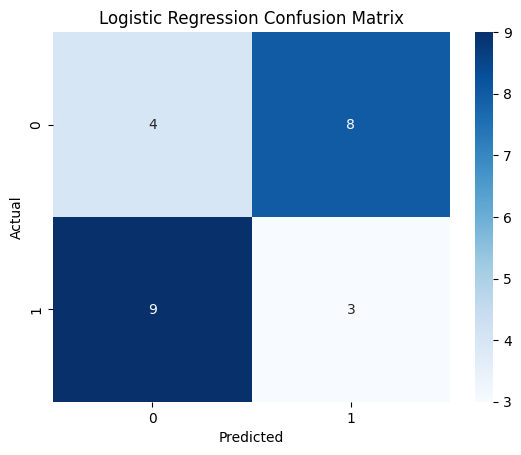

In [ ]:
# --- Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# 2. Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.38      0.25      0.30        12
           1       0.44      0.58      0.50        12

    accuracy                           0.42        24
   macro avg       0.41      0.42      0.40        24
weighted avg       0.41      0.42      0.40        24



In [ ]:
# Accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {acc_rf:.2f}")

Random Forest Accuracy: 0.42


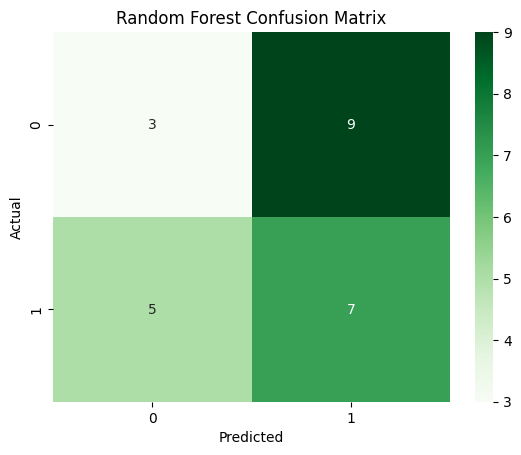

In [ ]:
# --- Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# 3. Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naive Bayes Results:")
print(classification_report(y_test, y_pred_nb))

Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.33      0.42      0.37        12
           1       0.22      0.17      0.19        12

    accuracy                           0.29        24
   macro avg       0.28      0.29      0.28        24
weighted avg       0.28      0.29      0.28        24



In [ ]:

# Accuracy
acc_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {acc_nb:.2f}")

Naive Bayes Accuracy: 0.29


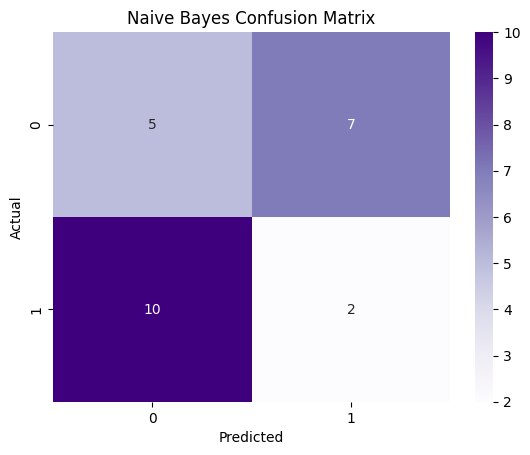

In [ ]:
# --- Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
!pip install transformers
from transformers import pipeline

# 4. Transformer (BERT small model)
classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Pick real sample headlines directly from the original dataset
sample_texts = df['headline'].sample(5, random_state=42).tolist()

for text in sample_texts:
    prediction = classifier(text)[0]
    print(f"Headline: {text}")
    print(f"Prediction: {prediction}\n")


Headline: Mike Flanagan is adapting Stephen King’s Carrie for Amazon
Prediction: {'label': 'POSITIVE', 'score': 0.5050272941589355}

Headline: Like on Prime Day, Amazon Is Offering 50% Off (Almost) All Fire TV Stick Stock Until Supplies Run Out
Prediction: {'label': 'NEGATIVE', 'score': 0.9993923902511597}

Headline: 22 Best MacBook Accessories (2025), Tested and Reviewed
Prediction: {'label': 'POSITIVE', 'score': 0.9995362758636475}

Headline: Beats Solo 4 Headphones Just Went From Full Price to Nearly Free, Thanks to Apple’s Massive Discount
Prediction: {'label': 'NEGATIVE', 'score': 0.9539090991020203}

Headline: Microsoft lets Copilot Studio use a computer on its own
Prediction: {'label': 'NEGATIVE', 'score': 0.9957576394081116}



<ipython-input-17-687a0f321128>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='pastel')


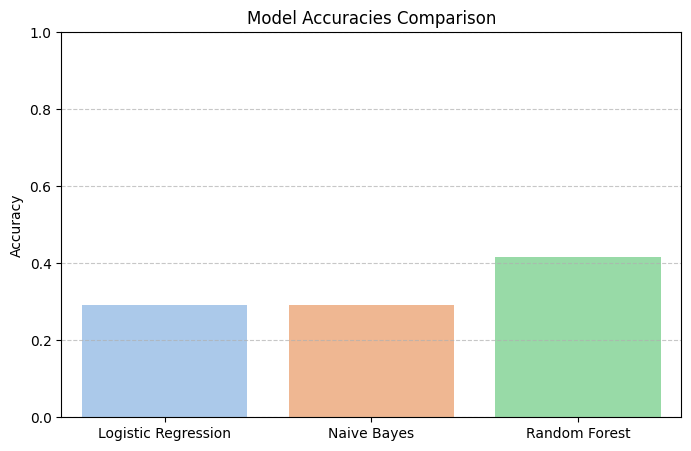

In [ ]:
# Compare All Model Accuracies
model_names = ['Logistic Regression', 'Naive Bayes', 'Random Forest']
accuracies = [acc_lr, acc_nb, acc_rf]

plt.figure(figsize=(8,5))
sns.barplot(x=model_names, y=accuracies, palette='pastel')
plt.title('Model Accuracies Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# @title  Large Language Models (LLMs)
from transformers import pipeline

print("Loading pipeline...")
text_generator = pipeline('text-generation', model='gpt2')
print("Pipeline loaded.")

prompt = "In the future, artificial intelligence will"
print("Generating text...")
result = text_generator(prompt, max_length=100, num_return_sequences=1)

print("Generated text:")
print(result[0]['generated_text'])


Loading pipeline...


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Pipeline loaded.
Generating text...
Generated text:
In the future, artificial intelligence will lead to people who work with computers interacting with them.

"It is something that will take quite a bit of time, in the future it will just be easy to replicate and adapt," said one Google employee involved.

"Right now you can work in your field. You can see the results of experiments that you take, but they tend to be not very good ones," said another.

Companies are looking to "change the nature of work


In [ ]:
import pandas as pd
from transformers import pipeline

# Assuming your headlines are in a list called 'headlines'
headlines = ["Apple releases new iPhone", "Microsoft announces new partnership", "Amazon stock prices fall"]
df = pd.DataFrame(headlines, columns=['headline']) # Create a DataFrame


sentiment_model = pipeline("sentiment-analysis")

# Apply to all headlines
df['sentiment'] = df['headline'].apply(lambda x: 1 if sentiment_model(x)[0]['label'] == 'POSITIVE' else 0)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# Generate embeddings
X_bert = np.vstack(df['headline'].apply(get_bert_embedding).values)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
classifier = pipeline("zero-shot-classification")
result = classifier(
    "Tesla stock tumbles after earnings report",
    candidate_labels=["bullish", "bearish", "neutral"]
)
print(result)


No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


{'sequence': 'Tesla stock tumbles after earnings report', 'labels': ['bearish', 'neutral', 'bullish'], 'scores': [0.9518895745277405, 0.03429075703024864, 0.01381969265639782]}


In [ ]:
summarizer = pipeline("summarization")
summary = summarizer("Long article about stock market...", max_length=50, min_length=25, do_sample=False)


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cuda:0
Your max_length is set to 50, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

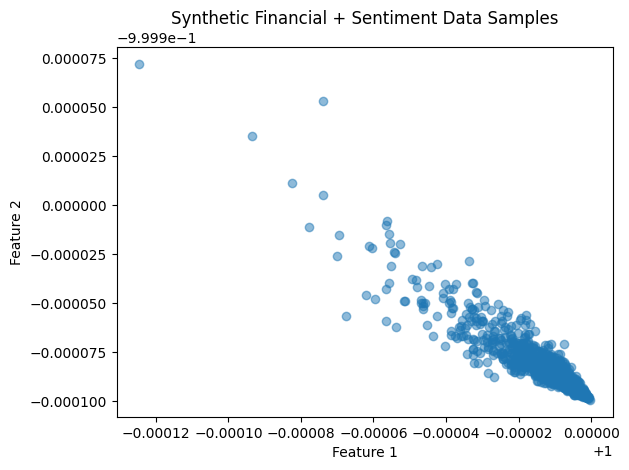

In [ ]:
# @title GAN (Trains the generator to fool the discriminator into classifying fake samples as real.)
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Dimensions
noise_dim = 100         # random noise input size
feature_dim = 128       # financial + sentiment feature size (example: 128 features)

# Generator
def build_generator():
    model = Sequential([
        Dense(256, input_dim=noise_dim),
        LeakyReLU(0.2),
        Dense(512),
        LeakyReLU(0.2),
        Dense(1024),
        LeakyReLU(0.2),
        Dense(feature_dim, activation='tanh')  # output feature vector
    ])
    return model

# Discriminator
def build_discriminator():
    model = Sequential([
        Dense(512, input_dim=feature_dim),
        LeakyReLU(0.2),
        Dense(256),
        LeakyReLU(0.2),
        Dense(1, activation='sigmoid')  # output: Real (1) or Fake (0)
    ])
    return model

# Build models
generator = build_generator()
discriminator = build_discriminator()

# Compile discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Combined model (for training generator)
discriminator.trainable = False
gan = Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))



# Assume you have your real training data features here:
# Example dummy data: 10,000 samples of 128 features
real_data = np.random.normal(0, 1, (10000, feature_dim))

epochs = 10000
batch_size = 64
half_batch = batch_size // 2

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select random real samples
    idx = np.random.randint(0, real_data.shape[0], half_batch)
    real_samples = real_data[idx]

    # Generate fake samples
    noise = np.random.normal(0, 1, (half_batch, noise_dim))
    fake_samples = generator.predict(noise)

    # Labels
    real_labels = np.ones((half_batch, 1))
    fake_labels = np.zeros((half_batch, 1))

    # Train on real and fake
    d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    valid_labels = np.ones((batch_size, 1))  # want discriminator to think generated data is valid

    g_loss = gan.train_on_batch(noise, valid_labels)

    # Print progress every 500 epochs
    if epoch % 500 == 0:
        print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}] [G loss: {g_loss:.4f}]")

# Generate Synthetic Data after training
n_samples = 1000
noise = np.random.normal(0, 1, (n_samples, noise_dim))
synthetic_data = generator.predict(noise)

print("Generated synthetic financial+sentiment feature samples:", synthetic_data.shape)

# Plot first 2 features for visualization
plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], alpha=0.5)
plt.title("Synthetic Financial + Sentiment Data Samples")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


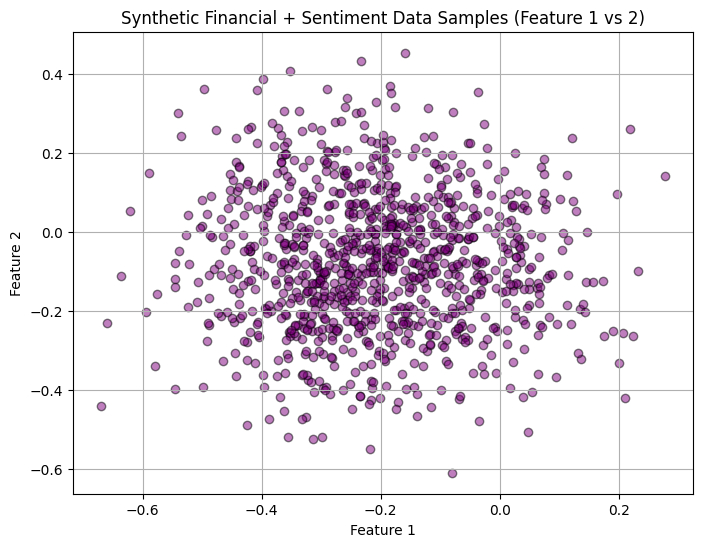

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU # Import LeakyReLU specifically
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Dimensions
noise_dim = 100         # random noise input size
feature_dim = 128       # financial + sentiment feature size (example: 128 features)

# Generator
def build_generator():
    model = Sequential([
        Dense(256, input_dim=noise_dim),
        LeakyReLU(0.2),  # Use LeakyReLU
        Dense(512),
        LeakyReLU(0.2),  # Use LeakyReLU
        Dense(1024),
        LeakyReLU(0.2),  # Use LeakyReLU
        Dense(feature_dim, activation='tanh')  # output feature vector
    ])
    return model
# Build models
generator = build_generator() # defines generator

# Define noise_dim (it was defined in previous cell, bring it here)
noise_dim = 100

# Regenerate synthetic data (if needed)
n_samples = 1000
noise = np.random.normal(0, 1, (n_samples, noise_dim))
synthetic_data = generator.predict(noise)

# Plot the first two features
plt.figure(figsize=(8, 6))
plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], alpha=0.5, color='purple', edgecolor='k')
plt.title("Synthetic Financial + Sentiment Data Samples (Feature 1 vs 2)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np # Import numpy

# Dimensions (bring these in from previous cell for context)
noise_dim = 100         # random noise input size
feature_dim = 128       # financial + sentiment feature size (example: 128 features)

# Regenerate real data here (as it was likely in a different cell):
real_data = np.random.normal(0, 1, (10000, feature_dim))

# Simulate binary labels for real data
# In a real scenario, you'd have actual sentiment labels here
real_labels = np.random.randint(0, 2, real_data.shape[0])

# Simulate labels for synthetic data (e.g., same distribution as real data or choose 1 class to balance)
synthetic_labels = np.random.randint(0, 2, synthetic_data.shape[0])

# Combine real and synthetic data
X_augmented = np.vstack((real_data, synthetic_data))
y_augmented = np.concatenate((real_labels, synthetic_labels))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

# Train a simple classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

print("Classification Report on Augmented Data:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report on Augmented Data:
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      1122
           1       0.49      0.50      0.49      1078

    accuracy                           0.50      2200
   macro avg       0.50      0.50      0.50      2200
weighted avg       0.50      0.50      0.50      2200

Accuracy: 0.4959090909090909


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Generate synthetic features
n_samples = 5000
noise = np.random.normal(0, 1, (n_samples, noise_dim))
synthetic_features = generator.predict(noise)

# Simulate labels: randomly assume 0 = bearish, 1 = bullish
# In real scenario, labels come from actual price movement based on technical analysis or future returns
synthetic_labels = np.random.randint(0, 2, (n_samples, 1)).ravel()

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(synthetic_features, synthetic_labels, test_size=0.2, random_state=42)

# Train a simple classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("Accuracy on synthetic test data:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy on synthetic test data: 0.499
              precision    recall  f1-score   support

           0       0.49      0.51      0.50       493
           1       0.51      0.49      0.50       507

    accuracy                           0.50      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       0.50      0.50      0.50      1000



In [ ]:
# Simulate a new stream of synthetic market+sentiment features
test_noise = np.random.normal(0, 1, (100, noise_dim))
test_features = generator.predict(test_noise)

# Predict market direction
market_signals = clf.predict(test_features)

# Simple action logic
# 1 = Bullish -> Buy, 0 = Bearish -> Sell
for i, signal in enumerate(market_signals[:10]):
    action = "Buy" if signal == 1 else "Sell"
    print(f"Signal {i+1}: {action}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Signal 1: Buy
Signal 2: Buy
Signal 3: Sell
Signal 4: Sell
Signal 5: Sell
Signal 6: Sell
Signal 7: Buy
Signal 8: Sell
Signal 9: Buy
Signal 10: Sell


In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

inputs = tokenizer("Hello, world!", return_tensors="pt")
outputs = model(**inputs)

print(outputs.last_hidden_state.shape)


torch.Size([1, 6, 768])


In [ ]:
# Sentiment analysis pipeline
from transformers import pipeline # Import the pipeline function

sentiment_pipeline = pipeline("sentiment-analysis")

# Example
text = "The stock market is experiencing a significant upswing amid economic recovery."
result = sentiment_pipeline(text)
print(result)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


[{'label': 'POSITIVE', 'score': 0.9978072047233582}]


In [ ]:
# @title Stable Diffusion model
!pip install torch # Install PyTorch if you haven't already
from diffusers import StableDiffusionPipeline
import torch

# Load without forcing float16
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float32)  # <-- or just remove torch_dtype

pipe.to("cpu")

prompt = "a futuristic city at sunset, ultra realistic"
image = pipe(prompt).images[0]
image.show()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

Generated image for signal 1: Buy


  0%|          | 0/50 [00:00<?, ?it/s]

Generated image for signal 2: Sell


  0%|          | 0/50 [00:00<?, ?it/s]

Generated image for signal 3: Sell


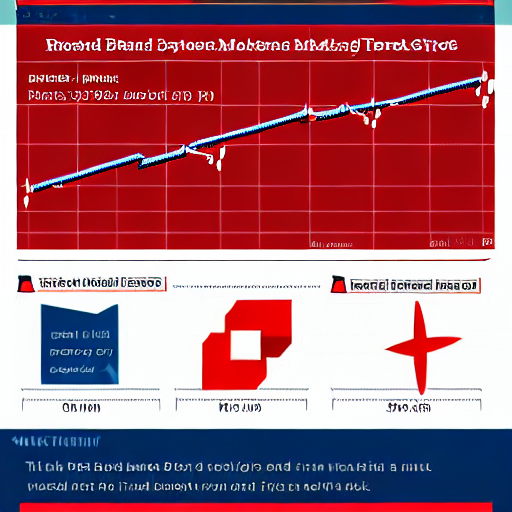

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from diffusers import StableDiffusionPipeline
import torch

# Load Stable Diffusion
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float32)
pipe.to("cpu")

# Define prompts based on predicted market direction
def generate_visual_signal(signal):
    if signal == 1:
        prompt = "a modern infographic showing bullish stock market trend, green arrows, stock growth, finance theme"
    else:
        prompt = "a modern infographic showing bearish stock market trend, red arrows, stock decline, finance theme"

    image = pipe(prompt).images[0]
    return image


# Dimensions (adjust if needed)
noise_dim = 100
feature_dim = 128

# --- Define a simple generator (replace with your actual generator if available) ---
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
# Generator
def build_generator():
    model = Sequential([
        Dense(256, input_dim=noise_dim),
        LeakyReLU(0.2),
        Dense(512),
        LeakyReLU(0.2),
        Dense(1024),
        LeakyReLU(0.2),
        Dense(feature_dim, activation='tanh')  # output feature vector
    ])
    return model

generator = build_generator()  # Create an instance of the generator
# --- End of generator definition ---

# Assuming 'generator' and 'clf' are already defined
# Example: Simulate data and train the classifier again

# Simulate training data for the model
synthetic_features = generator.predict(np.random.normal(0, 1, (1000, noise_dim)))
synthetic_labels = np.random.randint(0, 2, 1000)

# Re-train the model here if necessary (if 'clf' isn't defined)
clf = LogisticRegression(max_iter=1000)
clf.fit(synthetic_features, synthetic_labels)

# Simulate market+sentiment features
test_noise = np.random.normal(0, 1, (100, noise_dim))
test_features = generator.predict(test_noise)
market_signals = clf.predict(test_features)

# --- End of Simulation Setup ---

# Simulate for first 3 signals
for i, signal in enumerate(market_signals[:3]):
    image = generate_visual_signal(signal)
    print(f"Generated image for signal {i+1}: {'Buy' if signal==1 else 'Sell'}")
    from IPython.display import display

display(image)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating Bullish Image...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating Bearish Image...


  0%|          | 0/50 [00:00<?, ?it/s]

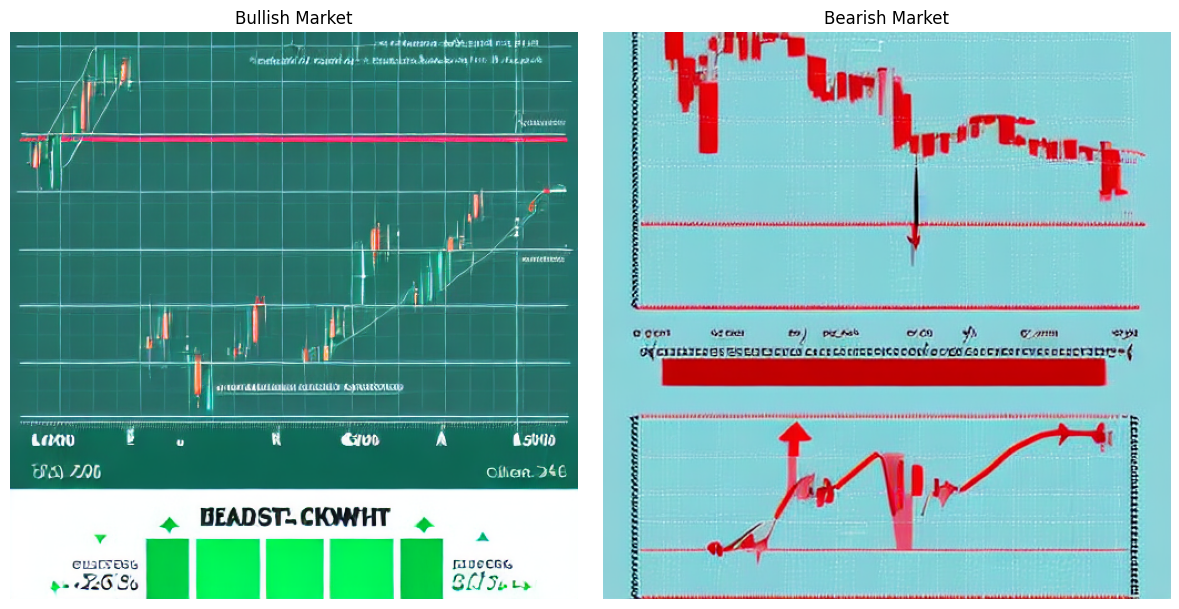

In [ ]:
# @title  Generate and Display Bullish vs. Bearish Images Side-by-Side
from diffusers import StableDiffusionPipeline
from IPython.display import display
import torch
import matplotlib.pyplot as plt

# Load the model once
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float32)
pipe.to("cpu")

# Define refined prompts
bullish_prompt = (
    "a professional infographic of a bullish stock market, green candles, upward arrow charts, "
    "investor optimism, financial growth, clean modern design"
)

bearish_prompt = (
    "a professional infographic of a bearish stock market, red candles, sharp downward graph, "
    "investor fear, loss arrows, red theme, minimal text"
)

# Generate images
print("Generating Bullish Image...")
bullish_image = pipe(bullish_prompt).images[0]

print("Generating Bearish Image...")
bearish_image = pipe(bearish_prompt).images[0]

# Plot them side-by-side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(bullish_image)
plt.axis("off")
plt.title("📈 Bullish Market")

plt.subplot(1, 2, 2)
plt.imshow(bearish_image)
plt.axis("off")
plt.title("📉 Bearish Market")

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(),
            nn.Linear(128, 300)  # Output could be 300-dim sentence embeddings
        )

    def forward(self, z):
        return self.model(z)

# Define discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(300, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Create models
G = Generator()
D = Discriminator()

# Optimizers
optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)

# Loss
criterion = nn.BCELoss()

# Dummy training loop
for epoch in range(1000):
    # Train Discriminator
    real_data = torch.randn(64, 300)  # Real embeddings
    fake_data = G(torch.randn(64, 100))  # Generated embeddings
    real_labels = torch.ones(64, 1)
    fake_labels = torch.zeros(64, 1)

    optimizer_D.zero_grad()
    loss_real = criterion(D(real_data), real_labels)
    loss_fake = criterion(D(fake_data.detach()), fake_labels)
    loss_D = (loss_real + loss_fake) / 2
    loss_D.backward()
    optimizer_D.step()

    # Train Generator
    optimizer_G.zero_grad()
    output = D(fake_data)
    loss_G = criterion(output, real_labels)
    loss_G.backward()
    optimizer_G.step()

print("Training finished ✅")


Training finished ✅
